In [3]:
from datasets import load_dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import chunk_and_tokenize, silence_datasets_messages
import torch as th

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
    assert isinstance(dataset, DatasetDict)
    silence_datasets_messages()

    dataset = chunk_and_tokenize(dataset, tokenizer)
    return model, tokenizer, dataset

gpt2, gpt2_tokenizer, gpt2_data = load_stuff("gpt2")

Found cached dataset wikitext (/mnt/ssd-1/nora/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
from white_box.utils import send_to_device
from tqdm.auto import tqdm
from white_box import record_residual_stream
from white_box.model_surgery import get_final_layer_norm
import torch.nn.functional as F

def compute_grad_alignment(model, data):
    device = next(model.parameters()).device
    model.eval()

    E = model.get_output_embeddings()
    ln = get_final_layer_norm(model)
    assert ln is not None

    alignment = None
    ll_alignment = None
    N = len(data["test"])

    def logit_lens_grad_alignment(h):
        global_grad = h.grad
        h.detach_()
        h.grad = None
        h.requires_grad = True
        h.retain_grad()

        logits = E(ln(h))
        loss = F.cross_entropy(
            logits[:, :-1].flatten(0, -2), item['input_ids'][:, 1:].flatten()
        )
        loss.backward()
        model.zero_grad()

        assert h.grad is not None
        return F.cosine_similarity(global_grad, h.grad, dim=-1).nanmean()

    with th.autocast('cuda', enabled=model.dtype == th.half):
        for i in tqdm(range(N)):
            # Hack because Pythia models require a batch dimension
            item = send_to_device(data["test"][i:i + 1], device)
            with record_residual_stream(model, retain_grads=True, sublayers=False) as stream:
                output = model(**item, labels=item['input_ids'])

            for h in stream:
                h.retain_grad()

            output.loss.backward()
            model.zero_grad()

            final_grads = stream.layers[-1].grad
            sample = stream.map(
                lambda x: F.cosine_similarity(x.grad, final_grads, dim=-1).nanmean()
            )
            if not alignment:
                alignment = sample
            else:
                alignment = alignment.mean_update(sample, i)
            
            # Logit lens gradient alignment
            ll_alignment_sample = stream.map(logit_lens_grad_alignment)
            if not ll_alignment:
                ll_alignment = ll_alignment_sample
            else:
                ll_alignment = ll_alignment.mean_update(ll_alignment_sample, i)

    assert alignment is not None and ll_alignment is not None
    return alignment, ll_alignment


  0%|          | 0/256 [00:00<?, ?it/s]

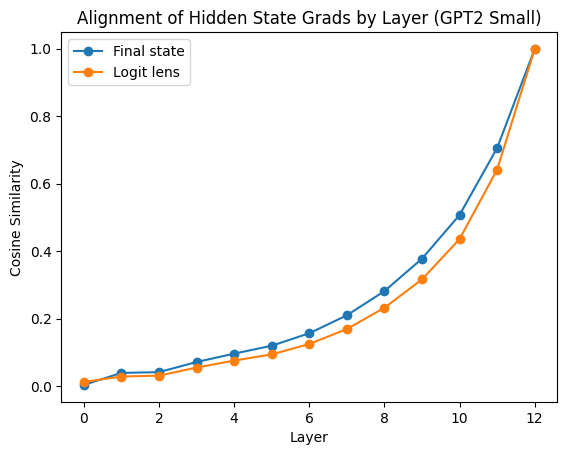

In [6]:
import matplotlib.pyplot as plt

gpt2_final_alignment, gpt2_ll_alignment = compute_grad_alignment(gpt2, gpt2_data)
gpt2_final_alignment.map(lambda x: x.cpu()).plot(marker='o', label="Final state")
gpt2_ll_alignment.map(lambda x: x.cpu()).plot(marker='o', label="Logit lens")
plt.title("Alignment of Hidden State Grads by Layer (GPT2 Small)")
plt.ylabel("Cosine Similarity")
plt.legend()

In [7]:
pythia, pythia_tokenizer, pythia_data = load_stuff("EleutherAI/pythia-1.3b", "cuda:1")

Found cached dataset wikitext (/mnt/ssd-1/nora/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Text(0, 0.5, 'Cosine Similarity with Final Hidden State Grad')

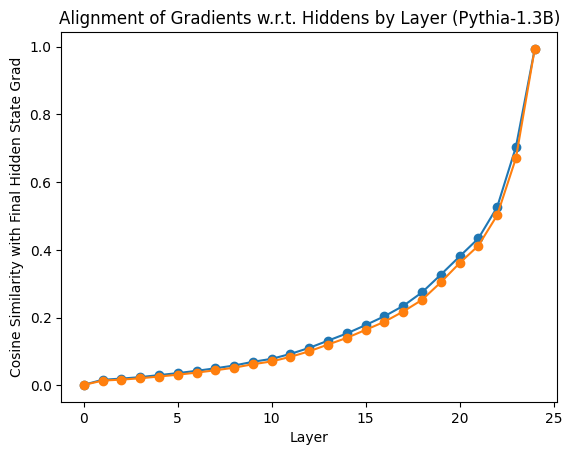

In [8]:
import matplotlib.pyplot as plt

pythia_final_alignment, pythia_ll_alignment = compute_grad_alignment(pythia, pythia_data)
pythia_final_alignment.map(lambda x: x.cpu()).plot(marker='o', label="Final state")
pythia_ll_alignment.map(lambda x: x.cpu()).plot(marker='o', label="Logit lens")
plt.title("Alignment of Gradients w.r.t. Hiddens by Layer (Pythia-1.3B)")
plt.ylabel("Cosine Similarity with Final Hidden State Grad")
plt.legend()